# Neural PDEs

In [1]:
%load_ext autoreload

In [86]:
%autoreload
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from spender2.custom_types import Array, Key
import random
from tqdm.auto import tqdm
from itertools import product


In [209]:
class SpectralConv1d(eqx.Module):
    in_channels: int = eqx.static_field()
    out_channels: int = eqx.static_field()
    modes: int = eqx.static_field()
    weights: Array
    
    def __init__(self, rng: Key, in_channels: int, out_channels: int, modes: int):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        scale = 1. / (in_channels * out_channels)
        self.weights = scale * jax.random.normal(rng, shape=(in_channels, out_channels, modes), dtype=jnp.complex64)

    def complex_mul1d(self, input, weights):
        return jnp.einsum("bix,iox->box", input, weights)
    
    def __call__(self, x: Array) -> Array:
        """Takes in an input Array of shape (in_channels, dims)
        and applies a spectral convolution to it. This is done by
        taking the Fourier transform of the input, multiplying the
        relevant modes by the weights, and then taking the inverse
        Fourier transform of the result.

        Inputs:
        =======
        x: Array of shape (batch, in_channels, dims)
            Input to the spectral convolution.
        
        Outputs:
        ========
        x: Array of shape (batch, out_channels, dims)
            Output of the spectral convolution.
        """
        x_ft = jnp.fft.rfft(x)
        out_ft = jnp.zeros((x.shape[0], self.out_channels, x.shape[-1]//2 + 1), dtype=jnp.complex64)
        out_ft = out_ft.at[:, :, :self.modes].set(self.complex_mul1d(x_ft[:, :, :self.modes], self.weights))
        x = jnp.fft.irfft(out_ft, n=x.shape[-1])
        return x


In [226]:
class FNO1D(eqx.Module):
    modes: int = eqx.static_field()
    width: int = eqx.static_field()
    time_future: int = eqx.static_field()
    time_past: int = eqx.static_field()
    hidden_size: int = eqx.static_field()
    n_layers: int = eqx.static_field()

    spectral_conv_layers: list
    conv_layers: list
    linear_layers: list
    activations: list = eqx.static_field()

    def __init__(self, rng: Key, modes: int, width: int, time_future: int, time_past: int, hidden_size: int = 128, n_layers: int = 4, activations = None):
        self.modes = modes
        self.width = width
        self.time_future = time_future
        self.time_past = time_past
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.spectral_conv_layers = []
        self.conv_layers = []
        self.linear_layers = []

        keys = jax.random.split(rng, n_layers * 2 + 3)

        for i in range(n_layers):
            self.spectral_conv_layers.append(SpectralConv1d(keys[2 * i], self.width, self.width, modes))
            self.conv_layers.append(eqx.nn.Conv(1, self.width, self.width, 1, padding=0, key=keys[2 * i + 1]))
        
        self.linear_layers.append(eqx.nn.Linear(self.time_past + 1, self.width, key=keys[-3]))
        self.linear_layers.append(eqx.nn.Linear(self.width, self.hidden_size, key=keys[-2]))
        self.linear_layers.append(eqx.nn.Linear(self.hidden_size, self.time_future, key=keys[-1]))

        if activations is None:
            self.activations = [jax.nn.gelu for _ in range(n_layers)]
        else:
            self.activations = activations
    
    def get_grid(self, shape: tuple) -> Array:
        batchsize, size_x = shape[0], shape[1]
        gridx = jnp.linspace(0, 1, size_x)
        gridx = jnp.repeat(gridx.reshape(1, size_x, 1), batchsize, axis=0)
        return gridx

    def apply_linear(self, linear_layer: eqx.nn.Linear, x: Array) -> Array:
        return linear_layer.weight @ x + linear_layer.bias[:, None]

    def __call__(self, x: Array) -> Array:
        grid = self.get_grid(x.shape)
        x = jnp.concatenate([x, grid], axis=-1)

        x = x.transpose(0, 2, 1)
        x = jax.vmap(self.apply_linear, in_axes=(None, 0))(self.linear_layers[0], x)
        # x = self.apply_linear(self.linear_layers[0], x)

        for i in range(self.n_layers):
            x1 = self.spectral_conv_layers[i](x)
            x2 = jax.vmap(self.conv_layers[i])(x)
            if i != self.n_layers - 1:
                x = self.activations[i](x1 + x2)
            else:
                x = x1 + x2

        x = jax.vmap(self.apply_linear, in_axes=(None, 0))(self.linear_layers[1], x)
        x = self.activations[-1](x)
        x = jax.vmap(self.apply_linear, in_axes=(None, 0))(self.linear_layers[2], x)
        return x

In [90]:
import h5py
import torch
from typing import Tuple
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#function to torch dataloader from the dataset
def create_dataloader(data_string: str, mode: str, nt: int, nx: int, batch_size:int, num_workers:int):
    try:
        dataset = HDF5Dataset(data_string,mode,nt=nt,nx=nx)
        loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, collate_fn=lambda x: tuple(map(jnp.stack, zip(*x))))
    except:
        raise Exception("Datasets could not be loaded properly")

    return loader


#Function to format the data in the correct format
def to_coords(x: Array, t: Array) -> Array:
    """
    Transforms the coordinates to a tensor X of shape [time, space, 2].
    Args:
        x: spatial coordinates
        t: temporal coordinates
    Returns:
        torch.Tensor: X[..., 0] is the space coordinate (in 2D)
                      X[..., 1] is the time coordinate (in 2D)
    """
    x_, t_ = jnp.meshgrid(x, t)
    x_, t_ = x_.T, t_.T
    return jnp.stack((x_, t_), -1)

#Helper class to open the .h5 formated file
class HDF5Dataset(Dataset):
    """
    Load samples of an PDE Dataset, get items according to PDE.
    """
    def __init__(self, path: str,
                 mode: str,
                 nt: int,
                 nx: int,
                 dtype=torch.float64,
                 load_all: bool=False):
        """Initialize the dataset object.
        Args:
            path: path to dataset
            mode: [train, valid, test]
            nt: temporal resolution
            nx: spatial resolution
            shift: [fourier, linear]
            pde: PDE at hand
            dtype: floating precision of data
            load_all: load all the data into memory
        """
        super().__init__()
        f = h5py.File(path, 'r')
        self.mode = mode
        self.dtype = dtype
        self.data = f[self.mode]
        self.dataset = f'pde_{nt}-{nx}'


        if load_all:
            data = {self.dataset: self.data[self.dataset][:]}
            f.close()
            self.data = data

    def __len__(self):
        return self.data[self.dataset].shape[0]

    def __getitem__(self, idx: int) -> Tuple[Array, Array, Array]:
        """
        Returns data items for batched training/validation/testing.
        Args:
            idx: data index
        Returns:
            torch.Tensor: data trajectory used for training/validation/testing
            torch.Tensor: dx
            torch.Tensor: dt
        """
        u = self.data[self.dataset][idx]
        x = self.data['x'][idx]
        t = self.data['t'][idx]
        dx = self.data['dx'][idx]
        dt = self.data['dt'][idx]


        if self.mode == "train":
            X = to_coords(jnp.array(x), jnp.array(t))
            sol = (jnp.array(u), X)

            u = sol[0]
            X = sol[1]
            dx = X[0, 1, 0] - X[0, 0, 0]
            dt = X[1, 0, 1] - X[0, 0, 1]
        else:
            u = jnp.array(u)
            dx = jnp.array([dx])
            dt = jnp.array([dt])
        return u, dx, dt

#function to create x - y data pairs: 20 past timepoints as x, 20 future timepoints as y
def create_data(datapoints: Array, start_time: list, time_future: int, time_history: int) -> Tuple[Array, Array]:
    """
    Getting data of PDEs for training.
    """

    data = []
    labels = []
    # Loop over batch and different starting points
    # For every starting point, we take the number of time_history points as training data
    # and the number of time future data as labels
    for (dp, start) in product(datapoints, start_time):
        end_time = start+time_history
        d = dp[start:end_time]
        target_start_time = end_time
        target_end_time = target_start_time + time_future
        l = dp[target_start_time:target_end_time]

        data.append(d[None, :])
        labels.append(l[None, :])

    return jnp.concatenate(data), jnp.concatenate(labels)

In [231]:
def loss_fn(model, data, labels):
    pred = model(data)
    loss = jnp.sum((pred - labels)**2)
    return loss

@eqx.filter_jit
def train_step(model, data, labels, optimizer, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(model, data, labels)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return loss, model, opt_state

In [242]:
nt = 140
nx = 256
ntrain = 512
batch_size = 16
time_history = 20
time_future = 20
width = 64
modes = 16
max_start_time = (nt - time_history) - time_future
train_loader = create_dataloader("data/KdV_train_10_1_3_512_easy.h5", mode="train", nt=nt, nx=nx, batch_size=batch_size, num_workers=0)
test_loader = create_dataloader("data/KdV_test_10_1_3_easy.h5", mode = "test", nt=nt, nx=nx, batch_size=batch_size, num_workers=0)
rng = jax.random.PRNGKey(0)
fno = FNO1D(rng, modes, width, time_future, time_history)

In [243]:
optimizer = optax.adam(5e-3)
opt_state = optimizer.init(fno)

In [296]:
# losses = []
for e in (pbar := tqdm(range(5))):
    epoch_loss = 0.
    for u, _, _ in train_loader:
        start_time = np.random.choice(np.arange(0, max_start_time + 1, time_history), replace=True, size=batch_size)
        data, labels = create_data(u, start_time, time_history, time_future)
        lv, fno, opt_state = train_step(fno, data.transpose(0, 2, 1), labels, optimizer, opt_state)
        losses.append(lv)
        epoch_loss += lv
    pbar.set_description(f"Epoch {e}, loss {epoch_loss}")

  0%|          | 0/5 [00:00<?, ?it/s]

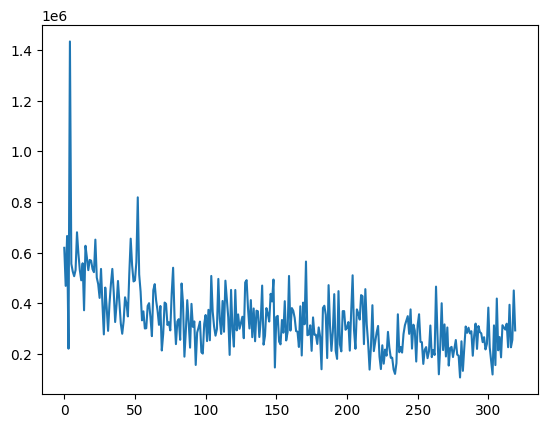

In [298]:
plt.plot(jnp.stack(losses))

In [302]:
u, _, _ = next(iter(test_loader))
traj_true = u[0]
traj_pred = []

traj_pred.append(u[:1,0:20])

for i in range(6):
    traj_pred.append(fno(traj_pred[-1].transpose(0, 2, 1)))
traj_pred = jnp.concatenate(traj_pred).reshape(-1, traj_pred[0].shape[-1])

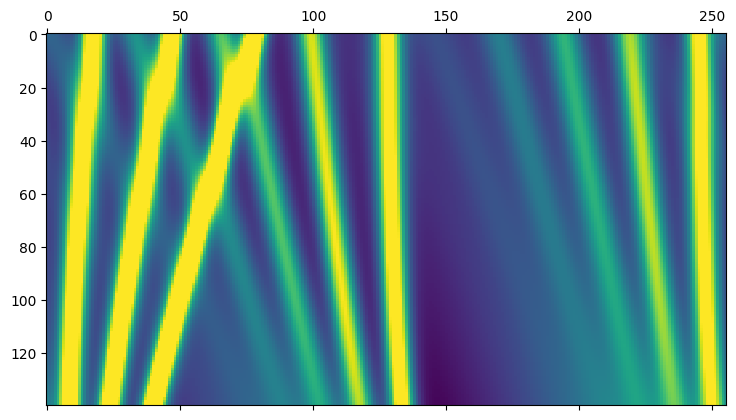

In [303]:
plt.matshow(traj_true, vmin=-1, vmax=1)

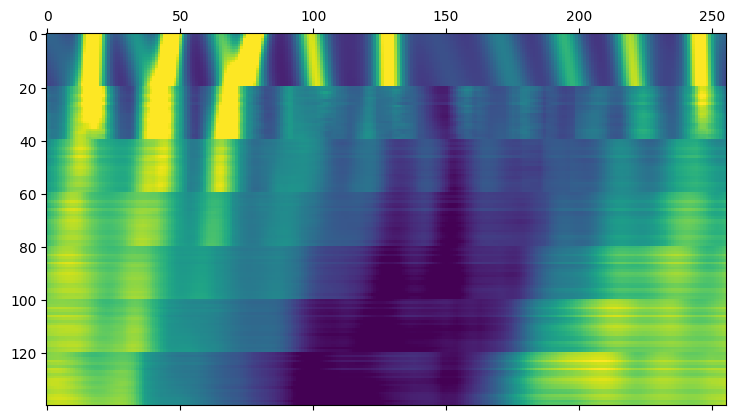

In [304]:
plt.matshow(traj_pred, vmin=-1, vmax=1)